<h1>PSO</h1>

In [1]:
from data_loader import DataLoader 
from neural_network import NeuralNetwork
from visualizer import Visualizer
import tensorflow as tf
import numpy as np
import time
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
class ParticleSwarmOptimization:
    def __init__(self, model, data_loader, num_particles=20, generations=3000,X=0.729, w=0.729, c1=2.05, c2=2.05, v_max=0.00525, v_min=-0.00525):
        self.model = model
        self.data_loader = data_loader
        self.num_particles = num_particles
        self.generations = generations
        self.X = X
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive weight
        self.c2 = c2  # Social weight
        self.v_max = v_max  # Maximum velocity
        self.v_min = v_min  # Minimum velocity
        self.dim = model.vector_size
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'population_states': []
        }
    
    def get_neighbors(self, i):
        """Get indices of neighbors in a ring topology"""
        return np.array([(i - 1) % self.num_particles, i, (i + 1) % self.num_particles])
    
    def train(self):
        """Run the PSO algorithm"""
        start_time = time.time()
        x_train, y_train, x_test, y_test = self.data_loader.get_data()
        
        # Initialize swarm
        swarm = np.array([self.model.he_vector() for _ in range(self.num_particles)])
        velocities = np.random.uniform(self.v_min, self.v_max, size=swarm.shape)
        
        # Initialize personal bests
        pbest = swarm.copy()
        pbest_fitness = np.array([self.model.fitness_function(ind, x_train, y_train) for ind in pbest])
        
        print(f"Starting Particle Swarm Optimization for {self.generations} generations...")
        
        for gen in range(self.generations):
            for i in range(self.num_particles):
                # Find local best (ring topology)
                neighbors = self.get_neighbors(i)
                lbest_index = neighbors[np.argmin(pbest_fitness[neighbors])]
                lbest = pbest[lbest_index]
                
                # Update velocity
                r1 = np.random.rand(swarm.shape[1])
                r2 = np.random.rand(swarm.shape[1])
                velocities[i] = self.X * (
                    velocities[i]
                    + self.c1 * r1 * (pbest[i] - swarm[i])
                    + self.c2 * r2 * (lbest - swarm[i])
                )
                velocities[i] = np.clip(velocities[i], self.v_min, self.v_max)
                
                # Update position
                swarm[i] += velocities[i]
                
                # Evaluate fitness
                fit = self.model.fitness_function(swarm[i], x_train, y_train)
                if fit < pbest_fitness[i]:
                    pbest[i] = swarm[i].copy()
                    pbest_fitness[i] = fit
            
            # Find best solution
            best_idx = np.argmin(pbest_fitness)
            best_solution = pbest[best_idx]
            best_loss = pbest_fitness[best_idx]
            
            # Update model with best solution and evaluate
            self.model.set_weights_from_vector(best_solution)
            train_loss, train_accuracy = self.model.evaluate(x_train, y_train)
            val_loss, val_accuracy = self.model.evaluate(x_test, y_test)
            
            # Store metrics
            self.history['loss'].append(train_loss)
            self.history['accuracy'].append(train_accuracy)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)
            
            # Store population state every 500 generations
            if gen % 500 == 0 or gen == self.generations - 1:
                self.history['population_states'].append({
                    'generation': gen,
                    'population': swarm.copy(),
                    'fitness': pbest_fitness.copy()
                })
            
            if gen % 100 == 0 or gen == self.generations - 1:
                print(f"Generation {gen+1}/{self.generations} - Best loss: {best_loss:.4f} - Accuracy: {val_accuracy:.4f}")
        
        # Set final best solution to the model
        best_idx = np.argmin(pbest_fitness)
        best_solution = pbest[best_idx]
        self.model.set_weights_from_vector(best_solution)
        
        execution_time = time.time() - start_time
        
        final_train_loss, final_train_accuracy = self.model.evaluate(x_train, y_train)
        final_val_loss, final_val_accuracy = self.model.evaluate(x_test, y_test)
        
        result = {
            'best_loss': min(self.history['val_loss']),
            'final_loss': final_val_loss,
            'final_accuracy': final_val_accuracy,
            'total_iterations': self.generations,
            'execution_time': execution_time,
            'history': self.history
        }
        
        return result

In [3]:
def run_particle_swarm_optimization():
    """Main function to run the Particle Swarm Optimization algorithm"""
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    print("Running Neural Network with Particle Swarm Optimization...")
    
    # Initialize data loader
    data_loader = DataLoader()
    
    # Initialize neural network
    model = NeuralNetwork(input_dim=784, hidden_dim=32, output_dim=10)
    
    # Initialize PSO optimizer
    pso_optimizer = ParticleSwarmOptimization(model, data_loader, num_particles=20, generations=3000)
    
    # Train the model
    results = pso_optimizer.train()
    
    # Save the model
    model.save_model('pso_model.pkl')
    
    # Visualize results
    visualizer = Visualizer(model, data_loader)
    visualizer.visualize_all(results)
    
    return model, results

Running Neural Network with Particle Swarm Optimization...
Starting Particle Swarm Optimization for 3000 generations...
Generation 1/3000 - Best loss: 2.2981 - Accuracy: 0.1385
Generation 101/3000 - Best loss: 2.2704 - Accuracy: 0.1394
Generation 201/3000 - Best loss: 2.1787 - Accuracy: 0.2290
Generation 301/3000 - Best loss: 1.9971 - Accuracy: 0.3313
Generation 401/3000 - Best loss: 1.6862 - Accuracy: 0.4191
Generation 501/3000 - Best loss: 1.4343 - Accuracy: 0.5055
Generation 601/3000 - Best loss: 1.2411 - Accuracy: 0.5725
Generation 701/3000 - Best loss: 1.0585 - Accuracy: 0.6349
Generation 801/3000 - Best loss: 0.9498 - Accuracy: 0.6750
Generation 901/3000 - Best loss: 0.8430 - Accuracy: 0.7074
Generation 1001/3000 - Best loss: 0.7613 - Accuracy: 0.7415
Generation 1101/3000 - Best loss: 0.7011 - Accuracy: 0.7616
Generation 1201/3000 - Best loss: 0.6503 - Accuracy: 0.7784
Generation 1301/3000 - Best loss: 0.5941 - Accuracy: 0.7958
Generation 1401/3000 - Best loss: 0.5591 - Accuracy:

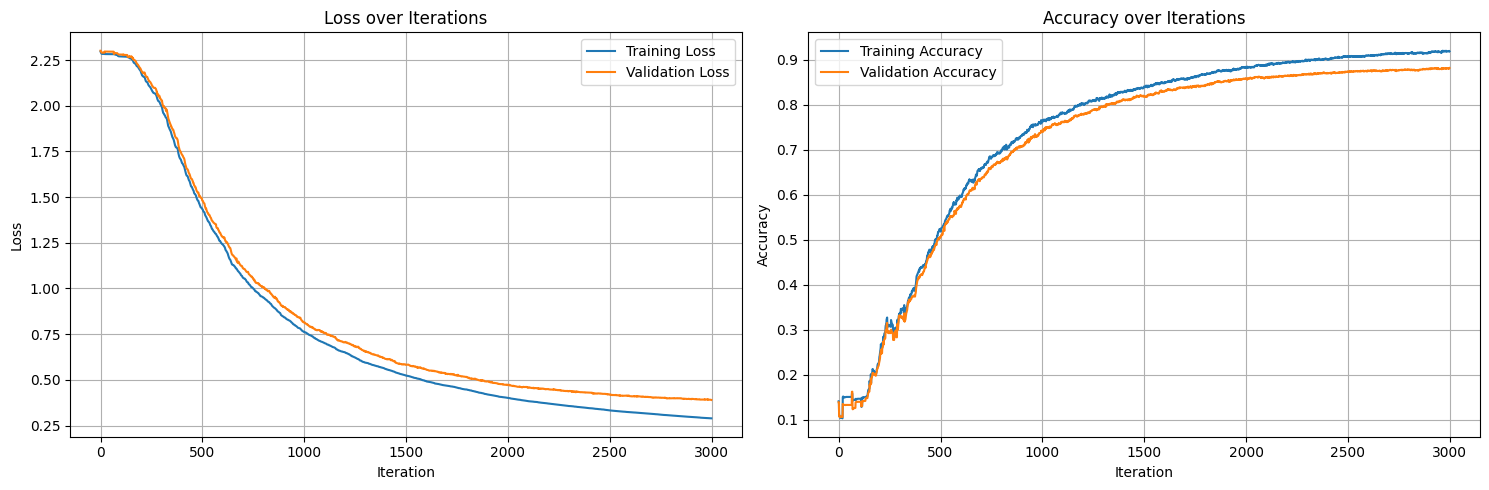

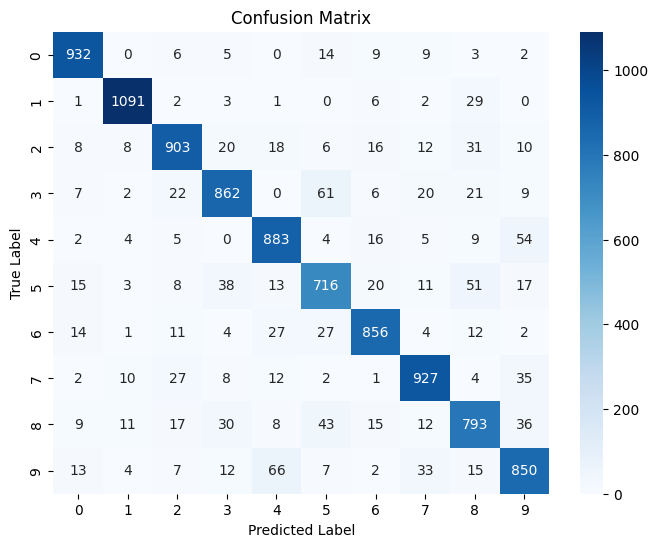

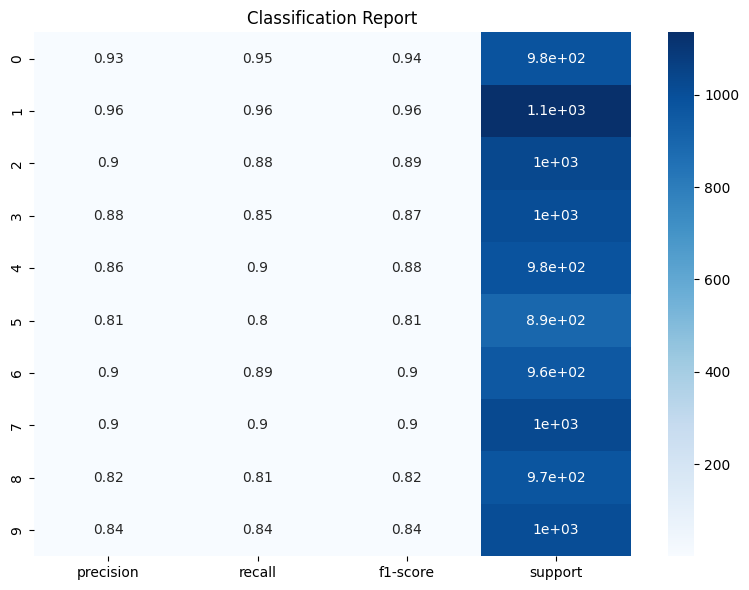

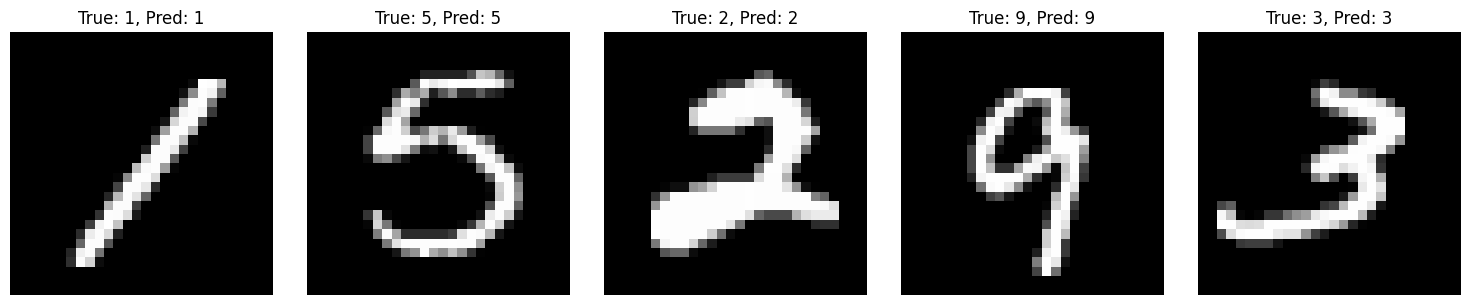

(<__main__.NeuralNetwork at 0x79ef5a62eed0>,
 {'best_loss': 0.3899713469529822,
  'final_loss': 0.3899713469529822,
  'final_accuracy': 0.8813,
  'total_iterations': 3000,
  'execution_time': 1018.8125591278076,
  'history': {'loss': [2.2980979860172304,
    2.2980979860172304,
    2.2920582319708447,
    2.288068804537308,
    2.286152868822043,
    2.2852012941889543,
    2.2847001820544626,
    2.2844058010867943,
    2.2842514086810675,
    2.2841587598746753,
    2.284098819885751,
    2.2840596138725604,
    2.2840339447724585,
    2.2840165804772172,
    2.284004436066563,
    2.283995771504777,
    2.2839898744265184,
    2.283985686719571,
    2.2839828326790457,
    2.283980771524891,
    2.2837696764570516,
    2.2834190998393815,
    2.2832512527673976,
    2.2831810915681525,
    2.2831600878235894,
    2.283151840943703,
    2.283147887418483,
    2.283147887418483,
    2.283147887418483,
    2.283147887418483,
    2.283147887418483,
    2.2830332872629997,
    2.28294234

In [149]:
run_particle_swarm_optimization()